In [ ]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

<a id="data"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 2. Reading and Understanding our Data </b></div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/00_MSC_Research/data_Folder/DataSet.csv', index_col=0)

In [ ]:
df.head()

statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

In [ ]:
df.describe()

statement  status
count               52681   53043
unique              51073       7
top     what do you mean?  Normal
freq                   22   16351

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Removing missing data

In [ ]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [ ]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

### Looking at target variable

In [ ]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

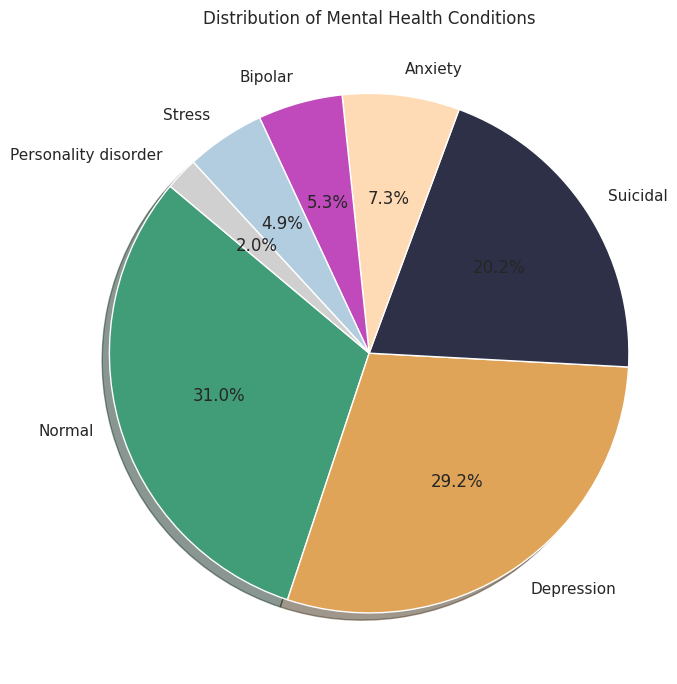

In [ ]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        The target variable in our dataset is <strong>unbalanced</strong>. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.
    </ul>
</div>

### Looking at raw texts

In [ ]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Seeking post-cancer anxiety advice I had cancer at 21 and been clear since but it created some serious anxiety. I get real aches and pains from the scars but also the fake aches and pains from anxiety, the trouble is differentiating between them. I usually get weird looks when I see a doctor about these aches and pains, so I feel embarrassed to see my general doctor. I have trouble keeping up with my cancer tests and follow ups because I’ve always been needle-phobic and get panic attacks when it comes to anything related to medical emergencies. I know better then to search WebMD, but if I hadn’t searched WebMD when I was 21 I wouldn’t have suspected a tumor and seen a doctor, so I have a fear that cancer is back or that there’s a real unrelated issue. I’m trying to see a psychiatrist, but does anyone have advice on how to deal with the health anxiety so it doesn’t get to the point where I feel the need to go to an ER? Is there any benefit to seeing a cardiolo

### Adding new features

In [ ]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


<div style="padding: 20px; border-color: #419D78; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #419D78;">
    <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em; ">
        We have several lengthy messages, most of which express suicidal thoughts or signs of depression:
    </ul>
</div>

In [ ]:
df[df['num_of_characters'] > 10000]

statement  \
7851   So introduction I guess.. my name is Michael a...   
9416   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
9504   Hello everyone,I rarely post on Reddit but.......   
10834  I have only 1 person I can somewhat open to bu...   
11537  The title is not meant to discourage others, b...   
11581  I no longer know what else to do but write thi...   
11636  And has life gotten better?&amp;#x200B;No. Eve...   
11831  Sorry this is long but I doubt anyone will eve...   
13293  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...   
18215  I am someone living in Turkey. My age is proba...   
21396  will i ever be noticed? is my life worth anyth...   
21858  I constantly repeat to myself that I have neve...   
22243  I do not expect anyone to read this rambly mes...   
22563  I have been thinking about posting online for ...   
23820  I need support or encouragement. I (29M) reall...   
23845  This is a a vent. I (29M) really do not know w...   
39752  it doesn t matter anymore i m going to copy an...   
46660  DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...   
51396  Please help me understand what I went through ...   

                     status  num_of_characters  num_of_sentences  
7851             Depression              10679               136  
9416               Suicidal              25302                 1  
9504             Depression              11163               139  
10834              Suicidal              27390               237  
11537            Depression              12304               155  
11581            Depression              13530               140  
11636            Depression              12819                96  
11831            Depression              11122               155  
13293              Suicidal              32759              1260  
18215              Suicidal              10219               180  
21396            Depression              12298               160  
21858            Depression              13054               149  
22243              Suicidal              12227               118  
22563              Suicidal              12028               132  
23820            Depression              11111               127  
23845              Suicidal              11075               133  
39752            Depression              19822                 1  
46660               Bipolar              26163               430  
51396  Personality disorder              27588               374

<a id="preprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 3. Text Preprocessing </b></div>

## 3.1. Lowercasing

Convert all statements to lowercase to ensure uniformity.

In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...

## 3.2. Removing URLs, handles, punctuation and special characters

To remove specific patterns such as URLs or other unwanted text (like ```[View Poll](https://www.reddit.com/poll/...)```) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods.

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless its been a month now ...

## 3.3. Tokenization

Split text into individual words or tokens.

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                                              tokens  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [all, wrong, back, off, dear, forward, doubt, ...  
3  [ive, shifted, my, focus, to, something, else,...  
4  [im, restless, and, restless, its, been, a, mo...

## 3.4. Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier

We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.

In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                                              tokens  \
0                                     [oh, my, gosh]   
1  [trouble, sleeping, confused, mind, restless, ...   
2  [all, wrong, back, off, dear, forward, doubt, ...   
3  [ive, shifted, my, focus, to, something, else,...   
4  [im, restless, and, restless, its, been, a, mo...   

                                      tokens_stemmed  
0                                         oh my gosh  
1  troubl sleep confus mind restless heart all ou...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shift my focu to someth els but im still w...  
4  im restless and restless it been a month now b...

## 3.5. Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

##  3.6. Word Clouds

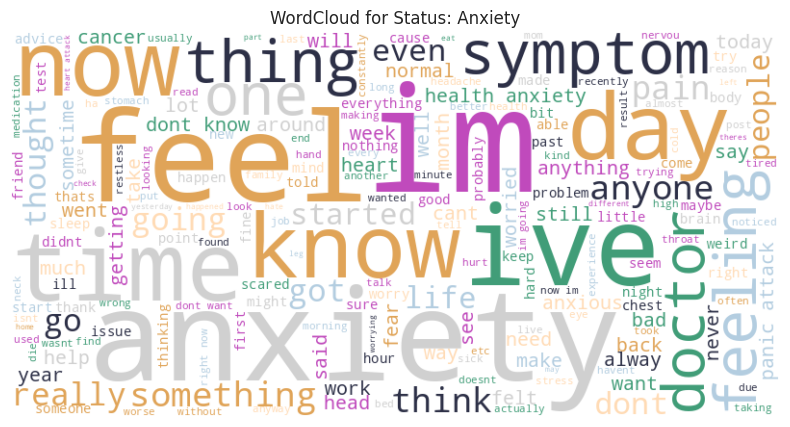

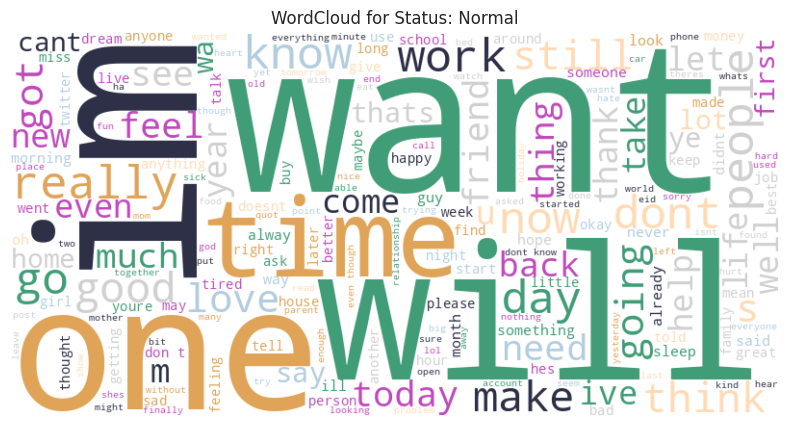

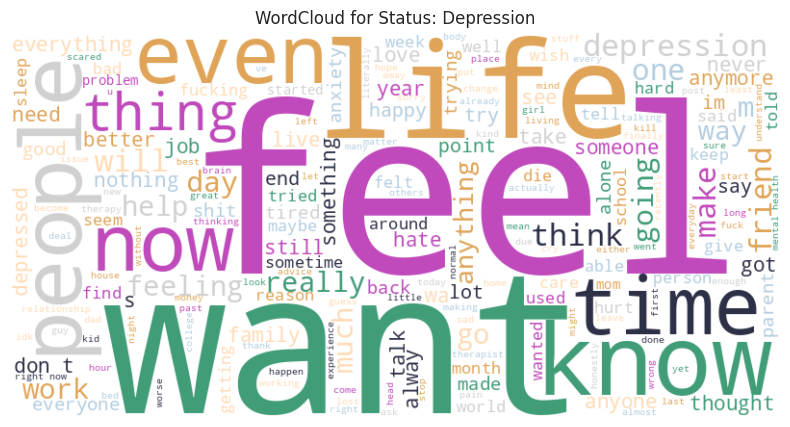

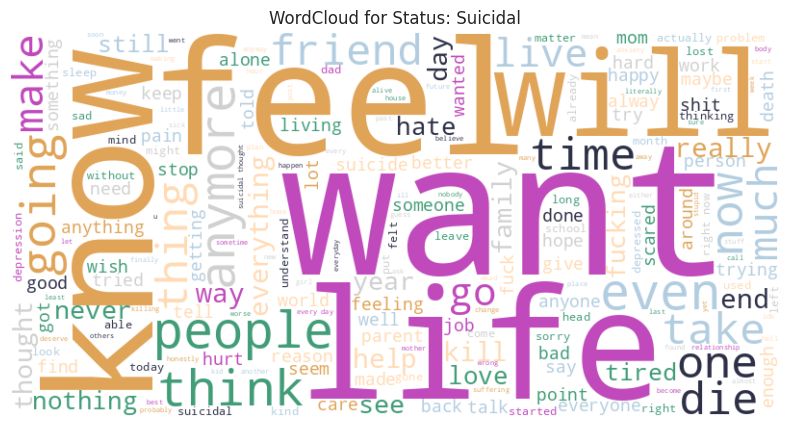

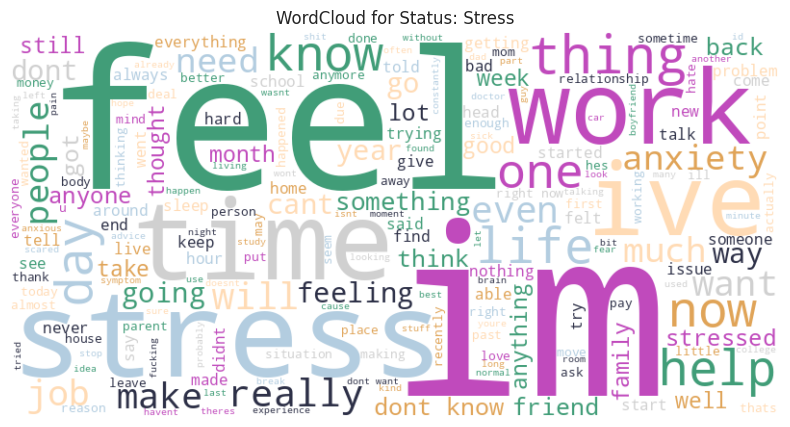

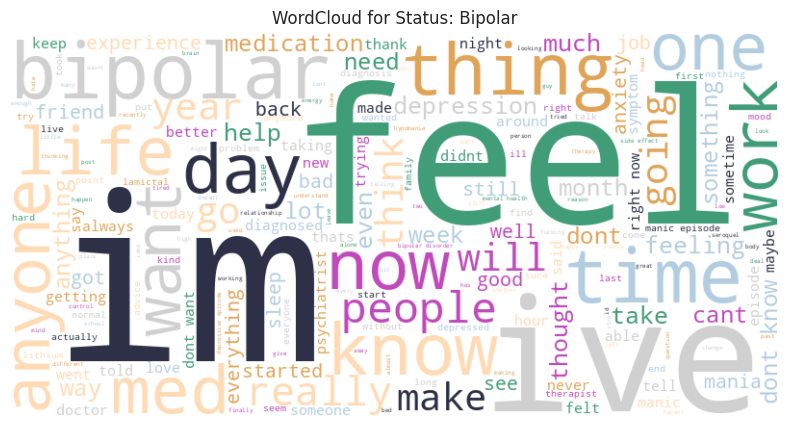

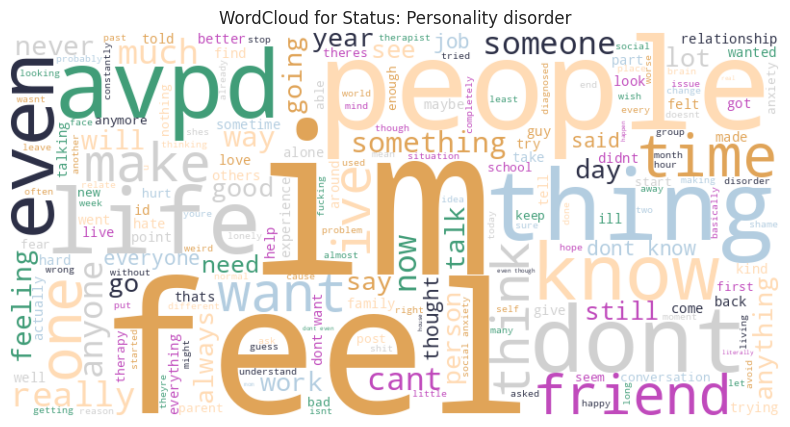

In [ ]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

<a id="datapreprocessing"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:9px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#419D78; overflow:hidden"><b> 4. Data Preprocessing </b></div>

## 4.1. Separate features and labels

In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

## 4.2. Label encoding target variable

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

## 4.3. Split the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## 4.4. Convert text to features using TF-IDF vectoriser

Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
X_train_combined.shape

(42144, 50002)

##4.5. Resampling

In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
X_train_resampled.shape

(91742, 50002)

#5.0 EDA

Exploratory data analysis for this dataset.

##5.1. Basic Overview

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())

# Data sample
df.sample(5, random_state=101)


Shape: (52681, 7)

Columns: ['original_statement', 'status', 'num_of_characters', 'num_of_sentences', 'statement', 'tokens', 'tokens_stemmed']

Missing values per column:
 original_statement    0
status                0
num_of_characters     0
num_of_sentences      0
statement             0
tokens                0
tokens_stemmed        0
dtype: int64


original_statement      status  \
11267  I am so tired . The worst part of this disease...  Depression   
32378         uh-oh. that means that she's fat and ugly.      Normal   
43562                                      is at work xx      Normal   
46110  This sounds like a mania induced purchase but ...     Bipolar   
15136  I am pathetic, I have been addicted to masturb...  Depression   

       num_of_characters  num_of_sentences  \
11267                787                19   
32378                 42                 2   
43562                 13                 1   
46110                644                10   
15136                742                10   

                                               statement  \
11267  i am so tired  the worst part of this disease ...   
32378             uhoh that means that shes fat and ugly   
43562                                      is at work xx   
46110  this sounds like a mania induced purchase but ...   
15136  i am pathetic i have been addicted to masturba...   

                                                  tokens  \
11267  [i, am, so, tired, the, worst, part, of, this,...   
32378    [uhoh, that, means, that, shes, fat, and, ugly]   
43562                                 [is, at, work, xx]   
46110  [this, sounds, like, a, mania, induced, purcha...   
15136  [i, am, pathetic, i, have, been, addicted, to,...   

                                          tokens_stemmed  
11267  i am so tire the worst part of thi diseas is t...  
32378               uhoh that mean that she fat and ugli  
43562                                      is at work xx  
46110  thi sound like a mania induc purchas but i swe...  
15136  i am pathet i have been addict to masturb and ...

##5.2. Class Distribution

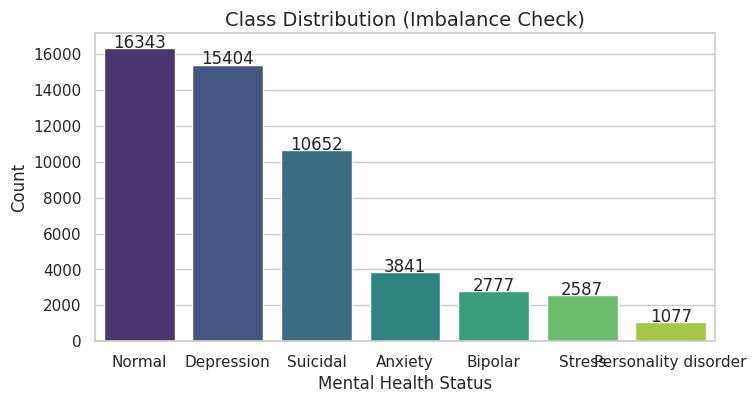

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64 

Class ratio (%):
status
Normal                  31.02
Depression              29.24
Suicidal                20.22
Anxiety                  7.29
Bipolar                  5.27
Stress                   4.91
Personality disorder     2.04
Name: count, dtype: float64


In [ ]:
status_counts = df['status'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title("Class Distribution (Imbalance Check)", fontsize=14)
plt.ylabel("Count"); plt.xlabel("Mental Health Status")
for i,v in enumerate(status_counts.values):
    plt.text(i, v+20, str(v), ha='center')
plt.show()

print(status_counts, "\n\nClass ratio (%):")
print(round(100 * status_counts / len(df), 2))


##5.3 Text Length Distribution

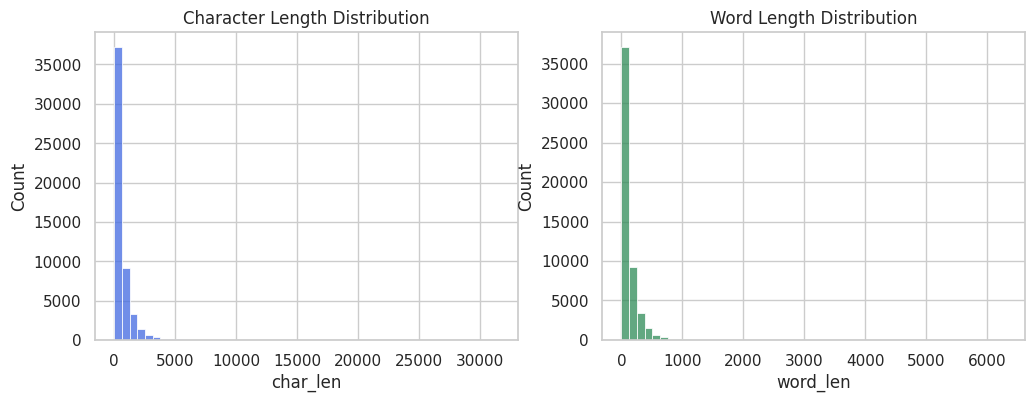

            count        mean         std  min   25%    50%    75%      max
char_len  52681.0  563.967768  826.776079  0.0  76.0  308.0  734.0  31499.0
word_len  52681.0  112.875932  163.479247  0.0  15.0   62.0  148.0   6300.0


In [ ]:
df['char_len'] = df['statement'].apply(len)
df['word_len'] = df['statement'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['char_len'], bins=50, ax=ax[0], color='royalblue')
ax[0].set_title("Character Length Distribution")
sns.histplot(df['word_len'], bins=50, ax=ax[1], color='seagreen')
ax[1].set_title("Word Length Distribution")
plt.show()

print(df[['char_len','word_len']].describe().T)


##5.4 Average Text Length per Class

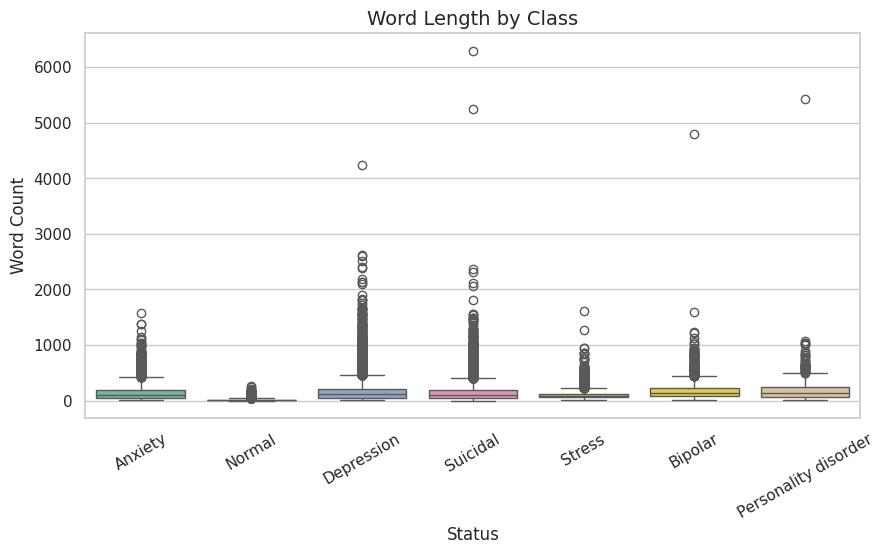

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='status', y='word_len', data=df, palette='Set2')
plt.title("Word Length by Class", fontsize=14)
plt.ylabel("Word Count"); plt.xlabel("Status")
plt.xticks(rotation=30)
plt.show()


##5.5 Common Words (Unigrams / Bigrams)

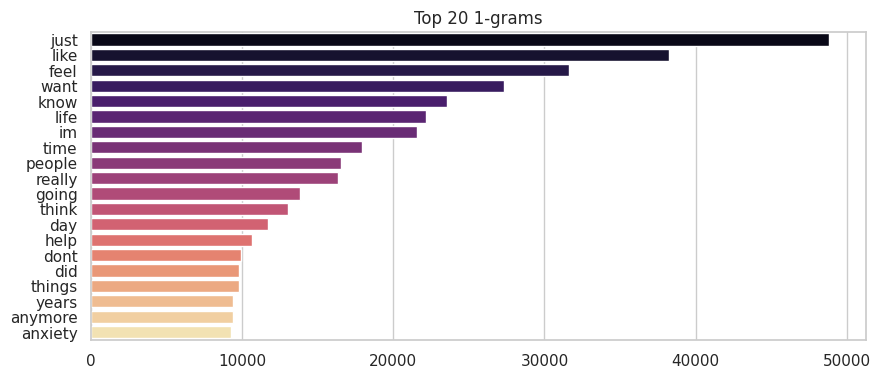

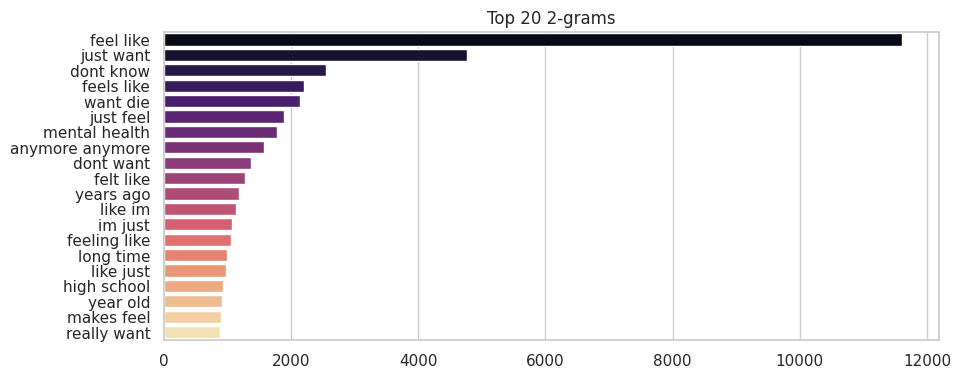

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

def show_top_ngrams(corpus, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    freqs = [(w, sum_words[0, i]) for w, i in vec.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:n]
    words = [w for w, _ in freqs]
    counts = [c for _, c in freqs]
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts, y=words, palette='magma')
    plt.title(f"Top {n} {ngram_range[0]}-grams")
    plt.show()

show_top_ngrams(df['statement'], n=20, ngram_range=(1,1))
show_top_ngrams(df['statement'], n=20, ngram_range=(2,2))


##5.6 Word Clouds per Class

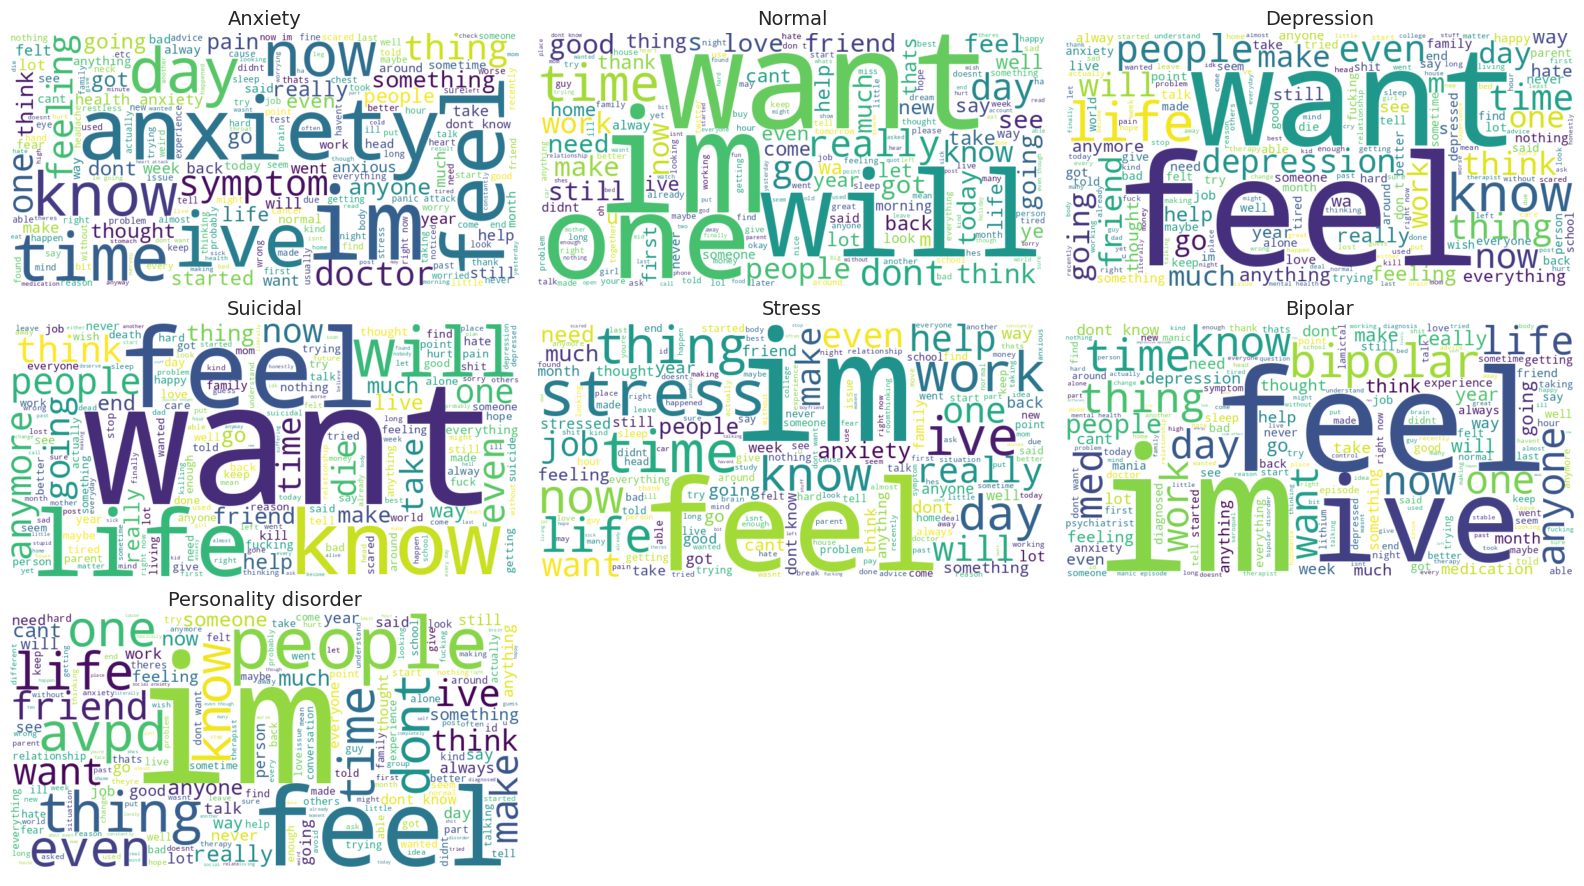

In [ ]:
# from wordcloud import WordCloud

# fig, axes = plt.subplots(2, 3, figsize=(16,9))
# axes = axes.flatten()
# for i, label in enumerate(df['status'].unique()):
#     text = " ".join(df[df['status']==label]['statement'].astype(str))
#     wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
#     axes[i].imshow(wc, interpolation='bilinear')
#     axes[i].set_title(label, fontsize=14)
#     axes[i].axis('off')
# plt.tight_layout()
# plt.show()


from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

labels = df['status'].unique()
num_labels = len(labels)

# Dynamically set rows and columns
cols = 3
rows = math.ceil(num_labels / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
axes = axes.flatten()

for i, label in enumerate(labels):
    text = " ".join(df[df['status'] == label]['statement'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(label, fontsize=14)
    axes[i].axis('off')

# Turn off unused subplot boxes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


##5.7. Correlation Between Text Features

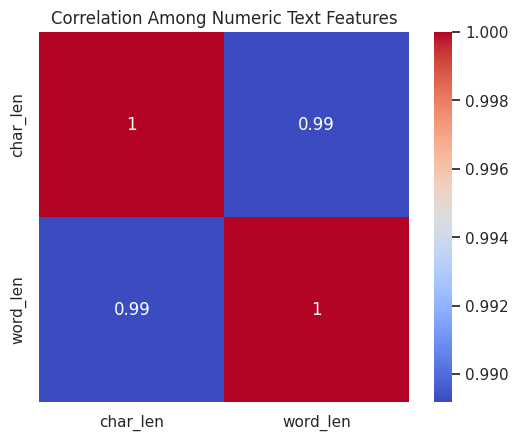

In [ ]:
features = ['char_len', 'word_len']
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Among Numeric Text Features")
plt.show()


##5.8. Vocabulary Diversity per Class

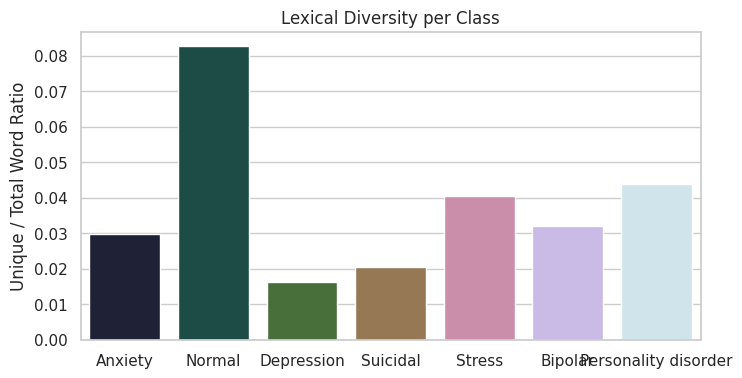

In [ ]:
from collections import Counter
def vocab_diversity(texts):
    all_tokens = " ".join(texts).split()
    return len(set(all_tokens)) / len(all_tokens)

diversity = {c: vocab_diversity(df[df['status']==c]['statement']) for c in df['status'].unique()}
plt.figure(figsize=(8,4))
sns.barplot(x=list(diversity.keys()), y=list(diversity.values()), palette='cubehelix')
plt.title("Lexical Diversity per Class")
plt.ylabel("Unique / Total Word Ratio")
plt.show()


##5.9. Sentiment Polarity (Optional)

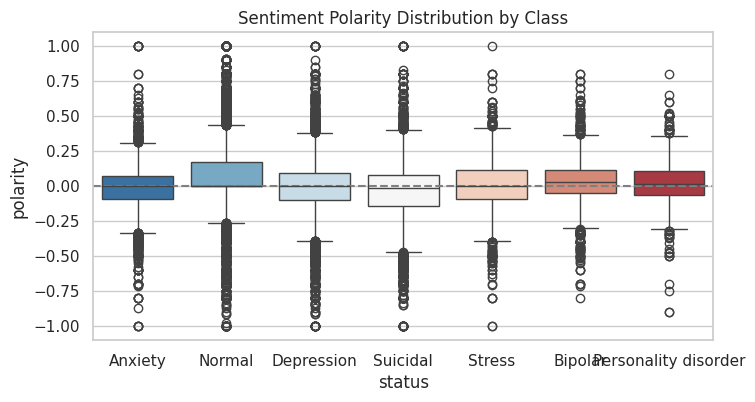

In [ ]:
from textblob import TextBlob
df['polarity'] = df['statement'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
plt.figure(figsize=(8,4))
sns.boxplot(x='status', y='polarity', data=df, palette='RdBu_r')
plt.title("Sentiment Polarity Distribution by Class")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


##5.10. N-gram Frequency Differences Between Classes

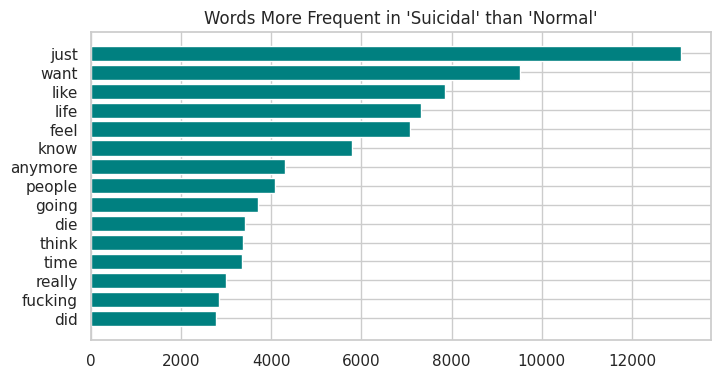

In [ ]:
# Compare two classes for discriminative words
def compare_keywords(class_a, class_b, topn=20):
    texts_a = " ".join(df[df['status']==class_a]['statement'])
    texts_b = " ".join(df[df['status']==class_b]['statement'])
    vec = CountVectorizer(stop_words='english', ngram_range=(1,1))
    bag = vec.fit_transform([texts_a, texts_b])
    freqs = np.array(bag.toarray())
    diff = freqs[0] - freqs[1]
    top_words = np.argsort(diff)[-topn:]
    vocab = np.array(vec.get_feature_names_out())
    plt.figure(figsize=(8,4))
    plt.barh(vocab[top_words], diff[top_words], color='teal')
    plt.title(f"Words More Frequent in '{class_a}' than '{class_b}'")
    plt.show()

compare_keywords("Suicidal", "Normal", topn=15)


##5.11. Outlier / Noise Check

In [ ]:
# Statements with very short or long lengths
short_texts = df[df['word_len'] < 3]
long_texts = df[df['word_len'] > df['word_len'].quantile(0.99)]
print("Very short samples:\n", short_texts.head(5))
print("\nVery long samples:\n", long_texts.head(3))


Very short samples:
     original_statement   status  num_of_characters  num_of_sentences  \
88             Anxious  Anxiety                  7                 1   
239   very nervous :')  Anxiety                 16                 1   
284        restless eh  Anxiety                 11                 1   
303       very nervous  Anxiety                 12                 1   
319       Very worried  Anxiety                 12                 1   

        statement           tokens tokens_stemmed  char_len  word_len  \
88        anxious        [anxious]         anxiou         7         1   
239  very nervous  [very, nervous]    veri nervou        12         2   
284   restless eh   [restless, eh]    restless eh        11         2   
303  very nervous  [very, nervous]    veri nervou        12         2   
319  very worried  [very, worried]     veri worri        12         2   

     polarity  
88      -0.25  
239      0.20  
284      0.00  
303      0.20  
319      0.20  

Very long 

##5.12. Class Co-occurrence in Multi-label Sources (if merged)

In [ ]:
duplicates = df[df.duplicated(subset=['statement'], keep=False)]
print("Duplicate samples:\n", duplicates.head())
print(f"Duplicate ratio: {len(duplicates)/len(df):.2%}")


Duplicate samples:
                                    original_statement   status  \
18  "No regrets or grudges/angry at things that ha...  Anxiety   
39  but my heart is still restless even though my ...  Anxiety   
53                        Restless.. and.. restless..  Anxiety   
56                                   why am i nervous  Anxiety   
78                             Restless and agitated.  Anxiety   

    num_of_characters  num_of_sentences  \
18                123                 1   
39                 62                 1   
53                 27                 1   
56                 16                 1   
78                 22                 1   

                                            statement  \
18  no regrets or grudgesangry at things that have...   
39  but my heart is still restless even though my ...   
53                              restless and restless   
56                                   why am i nervous   
78                              restles

##5.13. Optional: PCA / TSNE visualization on TF-IDF

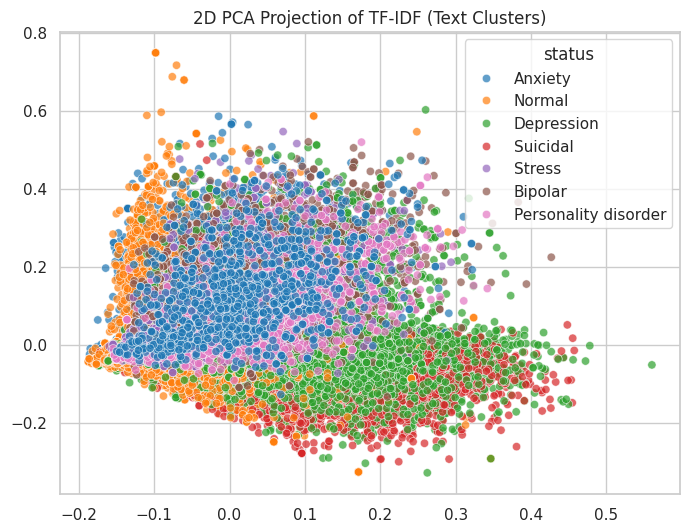

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['statement'])
X_pca = PCA(n_components=2, random_state=101).fit_transform(X_tfidf.toarray())
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['status'], palette='tab10', alpha=0.7)
plt.title("2D PCA Projection of TF-IDF (Text Clusters)")
plt.show()


Implement BERT And RoBERTA

In [ ]:
!pip install -q transformers datasets accelerate


In [ ]:
pip install transformers datasets accelerate


In [ ]:
import pandas as pd

# If df is already loaded, skip this
# df = pd.read_csv("your_dataset.csv")

print(df.head())
print(df.columns)


                                  original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                   

In [ ]:
df['statement'] = df['statement'].astype(str).fillna("")
df['status'] = df['status'].astype(str)


In [ ]:
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
y_all = lbl_enc.fit_transform(df['status'].values)
num_classes = len(lbl_enc.classes_)

print("Classes:", lbl_enc.classes_)
print("Number of classes:", num_classes)


Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Number of classes: 7


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 101
np.random.seed(SEED)

texts = df['statement'].astype(str).tolist()

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

print(len(X_train_text), len(X_test_text))


42144 10537


In [ ]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    weighted_f1 = f1_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "f1_macro": macro_f1,
        "f1_weighted": weighted_f1
    }


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
MAX_LEN = 256  # you can tune this later

train_encodings = tokenizer(
    X_train_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN
)

test_encodings = tokenizer(
    X_test_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN
)


In [ ]:
train_dataset = TextDataset(train_encodings, y_train)
test_dataset  = TextDataset(test_encodings, y_test)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([1.9592, 2.7107, 0.4886, 0.4605, 6.9844, 2.9085, 0.7066])


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        # forward pass
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")

        # weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


# class WeightedTrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights = class_weights

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         outputs = model(
#             input_ids=inputs["input_ids"],
#             attention_mask=inputs["attention_mask"]
#         )
#         logits = outputs.get("logits")

#         loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
#         loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss


In [ ]:
BATCH_SIZE = 16
EPOCHS = 4
LR = 2e-5

# training_args = TrainingArguments(
#     output_dir="./bert_mh_cls",
#     num_train_epochs=EPOCHS,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     learning_rate=LR,
#     weight_decay=0.01,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="f1_macro",
#     greater_is_better=True,
#     logging_steps=50,
#     save_total_limit=2,
#     seed=SEED
# )

training_args = TrainingArguments(
    output_dir=f"./{model_name.replace(' ', '_')}_mh_cls",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    eval_strategy="epoch",  # UPDATED
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    logging_dir=f"./logs_{model_name.replace(' ', '_')}",
    save_total_limit=2,
    seed=SEED,
    do_eval=True
)



In [ ]:
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()



BERT - Accuracy:   0.8367
BERT - Macro-F1:   0.8260

Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.87      0.90      0.89       768
             Bipolar       0.86      0.87      0.87       556
          Depression       0.83      0.73      0.77      3081
              Normal       0.95      0.95      0.95      3269
Personality disorder       0.76      0.85      0.80       215
              Stress       0.73      0.78      0.76       517
            Suicidal       0.70      0.80      0.75      2131

            accuracy                           0.84     10537
           macro avg       0.82      0.84      0.83     10537
        weighted avg       0.84      0.84      0.84     10537



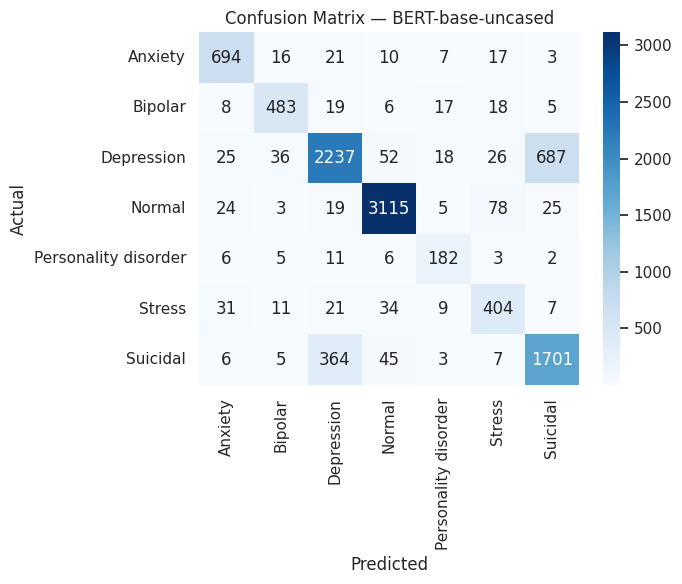

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_pred = np.argmax(logits, axis=1)

acc_bert = accuracy_score(y_test, y_pred)
macro_f1_bert = f1_score(y_test, y_pred, average='macro')

print(f"\nBERT - Accuracy:   {acc_bert:.4f}")
print(f"BERT - Macro-F1:   {macro_f1_bert:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=lbl_enc.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=lbl_enc.classes_,
    yticklabels=lbl_enc.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — BERT-base-uncased")
plt.tight_layout()
plt.show()


In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Re-encode with the SAME X_train_text / X_test_text
train_encodings = tokenizer(
    X_train_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN
)
test_encodings = tokenizer(
    X_test_text,
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN
)

train_dataset = TextDataset(train_encodings, y_train)
test_dataset  = TextDataset(test_encodings, y_test)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
).to(device)

training_args = TrainingArguments(
    output_dir="./roberta_mh_cls",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    save_total_limit=2,
    seed=SEED
    do_eval=True
)

trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()

# Evaluate RoBERTa
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_pred = np.argmax(logits, axis=1)

acc_rob = accuracy_score(y_test, y_pred)
macro_f1_rob = f1_score(y_test, y_pred, average='macro')

print(f"\nRoBERTa - Accuracy:   {acc_rob:.4f}")
print(f"RoBERTa - Macro-F1:   {macro_f1_rob:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=lbl_enc.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=lbl_enc.classes_,
    yticklabels=lbl_enc.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — RoBERTa-base")
plt.tight_layout()
plt.show()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
import pandas as pd

results_trf = [
    ("BERT-base-uncased", acc_bert, macro_f1_bert),
    ("RoBERTa-base",      acc_rob,  macro_f1_rob)
]

summary_trf = pd.DataFrame(results_trf, columns=['Model', 'Accuracy', 'Macro_F1'])
print(summary_trf.sort_values('Macro_F1', ascending=False).to_string(index=False))


Deep Learning Models (CNN, LSTM, GRU, Hybrid)

In [ ]:
# ============================================
# Deep Learning Models (CNN, LSTM, GRU, Hybrid)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set(style="whitegrid")

SEED = 101
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===============================
# 1. Prepare labels & encoder
# ===============================
assert 'statement' in df.columns and 'status' in df.columns, "df must have 'statement' and 'status'"

texts = df['statement'].astype(str).fillna("")

# Use existing lbl_enc if available; otherwise create a new one
try:
    lbl_enc
    print("Using existing LabelEncoder.")
    y = lbl_enc.transform(df['status'].values)
except NameError:
    print("Creating new LabelEncoder.")
    lbl_enc = LabelEncoder()
    y = lbl_enc.fit_transform(df['status'].values)

num_classes = len(lbl_enc.classes_)
print("Classes:", lbl_enc.classes_)

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.20, stratify=y, random_state=SEED
)

# ===============================
# 2. Tokenize & pad sequences
# ===============================
max_vocab = 100_000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=max_vocab, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_text.tolist())

X_train_seq = tokenizer.texts_to_sequences(X_train_text.tolist())
X_test_seq  = tokenizer.texts_to_sequences(X_test_text .tolist())

lengths = np.array([len(s) for s in X_train_seq if len(s) > 0] + [1])
max_len = int(min(500, np.percentile(lengths, 98)))  # long enough for context
max_len = max(max_len, 60)  # floor
print("Chosen max_len:", max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

vocab_size = min(max_vocab, len(tokenizer.word_index) + 1)
print("Vocab size (capped):", vocab_size)

# ===============================
# 3. Class weights (for imbalance)
# ===============================
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight)

# ===============================
# 4. Model builder functions
# ===============================
embedding_dim = 256
l2_reg = 1e-4
drop_embed = 0.25
drop_dense = 0.5

def build_cnn_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    # Multi-kernel CNN (3,4,5,7)
    def conv_block(x, k, filters=256):
        y = layers.Conv1D(filters, k, padding='same', activation='relu')(x)
        return y

    c3 = conv_block(x, 3); p3 = layers.GlobalMaxPooling1D()(c3)
    c4 = conv_block(x, 4); p4 = layers.GlobalMaxPooling1D()(c4)
    c5 = conv_block(x, 5); p5 = layers.GlobalMaxPooling1D()(c5)
    c7 = conv_block(x, 7); p7 = layers.GlobalMaxPooling1D()(c7)

    x = layers.Concatenate()([p3, p4, p5, p7])
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="CNN_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_bilstm_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    x = layers.Bidirectional(layers.LSTM(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="BiLSTM_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_bigru_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    x = layers.Bidirectional(layers.GRU(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="BiGRU_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_cnn_bilstm_model():
    """Hybrid CNN + BiLSTM"""
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    # CNN feature extractor
    c = layers.Conv1D(256, 5, padding='same', activation='relu')(x)
    c = layers.MaxPooling1D(pool_size=2)(c)

    # BiLSTM on top
    x = layers.Bidirectional(layers.LSTM(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(c)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="CNN_BiLSTM_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Dictionary of model builders
deep_model_builders = {
    "CNN_1D": build_cnn_model,
    "BiLSTM": build_bilstm_model,
    "BiGRU": build_bigru_model,
    "CNN_BiLSTM": build_cnn_bilstm_model,
}

# ===============================
# 5. Train & evaluate each model
# ===============================
results_dl = []  # (name, accuracy, macro_f1)
histories = {}

for name, builder in deep_model_builders.items():
    print("\n==============================")
    print(f"Training {name}...")
    print("==============================")

    model = builder()

    es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ckpt = callbacks.ModelCheckpoint(f"{name}_best.keras", monitor='val_loss', save_best_only=True, verbose=0)
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=64,
        class_weight=class_weight,
        callbacks=[es, ckpt, rlrop],
        verbose=1
    )
    histories[name] = history.history

    # Load best weights
    best_model = tf.keras.models.load_model(f"{name}_best.keras")
    y_prob = best_model.predict(X_test_pad, batch_size=256, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{name} - Accuracy:  {acc:.4f}")
    print(f"{name} - Macro-F1:  {macro_f1:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=lbl_enc.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6.5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    # Save metrics
    results_dl.append((name, acc, macro_f1))

# ===============================
# 6. Summary of deep model results
# ===============================
print("\n=== Deep Learning Models Performance Summary (sorted by Macro-F1) ===")
summary_dl = pd.DataFrame(results_dl, columns=['Model', 'Accuracy', 'Macro_F1']).sort_values('Macro_F1', ascending=False)
print(summary_dl.to_string(index=False))
